In [328]:
#Imporing libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.autograd import Variable
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression

# ==============================================================================================================
# [26 Mei 2020]: ditambahkan agar angka random selalu sama ketika program dijalankan, sehingga hasil selalu sama
# ==============================================================================================================
np.random.seed(1234)
torch.manual_seed(1234)

In [329]:
#Reading data
dataset = pd.read_csv(r"Churn_Modelling.csv")
pd.options.display.max_columns = None
# dataset

In [330]:
#Defining columns
categorical_columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

outputs = ['Exited']

In [331]:
#Processing columns
scaler = StandardScaler()

## NUMERICAL
#convert our numerical columns to tensors
numerical_data = np.stack([dataset[col].values for col in numerical_columns], 1)

# 22 Juni 2020: memperbaiki cara menggunakan scaler
numerical_data = scaler.fit_transform(numerical_data)
numerical_data = torch.tensor(numerical_data, dtype=torch.float)

## CATEGORICAL
#convert the types for categorical columns to category
for category in categorical_columns:
    dataset[category] = dataset[category].astype('category')

# convert data in the four categorical columns into numpy arrays and then stack all the columns horizontally
geo = dataset['Geography'].cat.codes.values
gen = dataset['Gender'].cat.codes.values
hcc = dataset['HasCrCard'].cat.codes.values
iam = dataset['IsActiveMember'].cat.codes.values

categorical_data = np.stack([geo, gen, hcc, iam], 1)
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)

## OUTPUT
#convert the output numpy array into a tensor object

dataset[outputs] = dataset[outputs].astype(int)
outputs = torch.tensor(dataset[outputs].values).flatten()
outputs = outputs.long()

In [332]:
#divide our dataset into training and test sets
total_records = 10000

# **********************************************************************************************************************
train_records = int(total_records * .6)
valid_records = int(total_records * .2)
test_records = int(total_records * .2)

# **********************************************************************************************************************
numerical_train_data = numerical_data[:train_records]
numerical_valid_data = numerical_data[train_records:train_records+valid_records]
numerical_test_data = numerical_data[train_records+valid_records:total_records]

# **********************************************************************************************************************
categorical_train_data = categorical_data[:train_records]
categorical_valid_data = categorical_data[train_records:train_records+valid_records]
categorical_test_data = categorical_data[train_records+valid_records:total_records]

# **********************************************************************************************************************
train_outputs = outputs[:train_records]
valid_outputs = outputs[train_records:train_records+valid_records]
test_outputs = outputs[train_records+valid_records:total_records]

In [333]:
#define a class named Model, which will be used to train the model

class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(6,50) #NUMERICAL
        self.act1 = nn.ReLU(inplace=True)         
        self.layer2 = nn.Linear(70,100)           
        self.layer3 = nn.Linear(100,2)
        
        #CATEGORICAL
        self.layer1_1 = nn.Embedding(3, 5)
        self.layer1_2 = nn.Embedding(2, 5)
        self.layer1_3 = nn.Embedding(2, 5)
        self.layer1_4 = nn.Embedding(2, 5)
        
        #DECODER
        self.decoder_categorical_1 = nn.Linear(100,3)
        self.decoder_categorical_2 = nn.Linear(100,2)
        self.decoder_categorical_3 = nn.Linear(100,2)
        self.decoder_categorical_4 = nn.Linear(100,2)
        
        self.decoder_numerical = nn.Linear(100,6)
        
    def forward(self, x_categorical, x_numerical):
        x1 = self.layer1(x_numerical)
        
        x1_embedding = self.layer1_1(x_categorical[:,0])
        x2_embedding = self.layer1_2(x_categorical[:,1])
        x3_embedding = self.layer1_3(x_categorical[:,2])
        x4_embedding = self.layer1_4(x_categorical[:,3])
        x_embedding = torch.cat([x1_embedding,x2_embedding,x3_embedding,x4_embedding], 1)
        
        x1_1 = torch.cat([x1, x_embedding], 1)
        x1_act = self.act1(x1_1)
        
        #DECODER
        x2 = self.layer2(x1_act)
        
        x3 = self.layer3(x2) #OUTPUT CHURN /ENGGA
        
        categorical_1_decoded = self.decoder_categorical_1(x2)
        categorical_2_decoded = self.decoder_categorical_2(x2)
        categorical_3_decoded = self.decoder_categorical_3(x2)
        categorical_4_decoded = self.decoder_categorical_4(x2)
        
        numerical_decoded = self.decoder_numerical(x2)
        
        return x2, x3, categorical_1_decoded, categorical_2_decoded, categorical_3_decoded, categorical_4_decoded, numerical_decoded

In [334]:
model = Model()

In [335]:
#DEFINE LOSS FUNCTION & OPTIMIZER
churn_percentage = 0.8

loss_function = nn.CrossEntropyLoss(weight=torch.Tensor([1-churn_percentage, churn_percentage]))
loss_function_autoencoder = nn.CrossEntropyLoss() #classification - categorical

loss_function_mse = nn.MSELoss() #regression - numerical

optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #learning rate
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [336]:
# train the model
epochs = 50 #JUMLAH BERAPA KALI DATASET DIGUNAKAN UNTUK TRAIN MODEL
len_train_data = 6000 # 22 Juni 2020: ini tadinya salah, menggunakan 10.000, yang merupakan jumlah seluruh data, bukan data training saja
batch_size = 10

# ***********************************************************
mean_losses_train = []
mean_losses_valid = []

mean_losses_train_autoencoder = []
mean_losses_valid_autoencoder = []

mean_losses_train_classification = []
mean_losses_valid_classification = []

best_loss_valid = np.inf

# **********************************************************************************************************************
ae_ratio = 0.5
ae_scale = 0.1

for i in range(epochs):
    # *************************************************************************************************************
    # 22 Juni 2020: rasio loss autoencoder dibuat mengikuti fungsi yang turun secara eksponensial dimulai dari 0.5
    # Tujuannya agar semakin lama, pengaruh loss classification menjadi semakin kuat.
    # Penurunan rasio ini dibutuhkan karena tujuan utama model adalah klasifikasi, 
    # sedangkan autoencoder hanya sebagai tambahan untuk memperkuat kemampuan klasifikasi
    # *************************************************************************************************************
    aggregated_losses = []
    aggregated_losses_valid = []
    
    aggregated_losses_autoencoder = []
    aggregated_losses_valid_autoencoder = []
    
    aggregated_losses_classification = []
    aggregated_losses_valid_classification = []
    
    mean_losses = []
    
    # 22 Juni 2020: ditambahkan random permutation untuk shuffle data training
    idxs = np.random.permutation(len_train_data)
    for j in range(len_train_data // batch_size):
        start = j * batch_size
        end = start + batch_size

        idxs_batch = idxs[start:end] # 22 Juni 2020: untuk shuffle data training
        
        optimizer.zero_grad()
# **********************************************************************************************************************
        # 22 Juni 2020: input diganti dengan categorical_train_data dan numerical_train_data
        y_embed, y_pred, categorical_1_decoded, categorical_2_decoded, categorical_3_decoded, categorical_4_decoded, numerical_decoded = model(categorical_train_data[idxs_batch],numerical_train_data[idxs_batch])
        
        # 22 Juni 2020: nama loss dibedakan antara train dan validasi, outputs diganti jadi train_outputs
        classification_loss_train = loss_function(y_pred, train_outputs[idxs_batch])        
        
        categorical_1_loss_train = loss_function_autoencoder(categorical_1_decoded, categorical_data[start:end][:,0])
        categorical_2_loss_train = loss_function_autoencoder(categorical_2_decoded, categorical_data[start:end][:,1])
        categorical_3_loss_train = loss_function_autoencoder(categorical_3_decoded, categorical_data[start:end][:,2])
        categorical_4_loss_train = loss_function_autoencoder(categorical_4_decoded, categorical_data[start:end][:,3])
        
        numerical_loss_train = loss_function_mse(numerical_decoded, numerical_train_data[start:end])
        
        autoencoder_loss_train = ae_scale*(categorical_1_loss_train + categorical_2_loss_train + categorical_3_loss_train + categorical_4_loss_train + numerical_loss_train)
        single_loss = ((1-ae_ratio)*classification_loss_train) + (ae_ratio*autoencoder_loss_train)
        
        aggregated_losses_autoencoder.append(autoencoder_loss_train)
        aggregated_losses_classification.append(classification_loss_train)
        aggregated_losses.append(single_loss)

#         print(f'batch: {j:3} loss: {single_loss.item():10.8f}')

        single_loss.backward()
        optimizer.step()

    aggregated_losses_autoencoder = torch.stack(aggregated_losses_autoencoder)
    aggregated_losses_classification = torch.stack(aggregated_losses_classification)
    aggregated_losses = torch.stack(aggregated_losses)
    
    mean_losses_autoencoder = torch.mean(aggregated_losses_autoencoder)
    mean_losses_classification = torch.mean(aggregated_losses_classification)
    mean_losses = torch.mean(aggregated_losses)
    
    print(f'epoch: {i:3} mean loss training: {mean_losses.item():.8f}')
    
    mean_losses_train_autoencoder.append(mean_losses_autoencoder)
    mean_losses_train_classification.append(mean_losses_classification)
    mean_losses_train.append(mean_losses)
    
    # ==============================================================================================
    # validation
    # ==============================================================================================
    with torch.set_grad_enabled(False):
        for k in range((valid_records//batch_size)):
            start_valid = k*batch_size
            end_valid = start_valid+batch_size
            
            # 22 Juni 2020: input diganti dengan categorical_valid_data dan numerical_valid_data
            y_embed, y_pred, categorical_1_decoded, categorical_2_decoded, categorical_3_decoded, categorical_4_decoded, numerical_decoded = model(categorical_valid_data[start_valid:end_valid],numerical_valid_data[start_valid:end_valid])
            
            # 22 Juni 2020: nama loss dibedakan antara train dan validasi, outputs diganti jadi valid_outputs
            classification_loss_valid = loss_function(y_pred, valid_outputs[start_valid:end_valid])
        
            categorical_1_loss_valid = loss_function_autoencoder(categorical_1_decoded, categorical_data[start:end][:,0])
            categorical_2_loss_valid = loss_function_autoencoder(categorical_2_decoded, categorical_data[start:end][:,1])
            categorical_3_loss_valid = loss_function_autoencoder(categorical_3_decoded, categorical_data[start:end][:,2])
            categorical_4_loss_valid = loss_function_autoencoder(categorical_4_decoded, categorical_data[start:end][:,3])

            numerical_loss_valid = loss_function_mse(numerical_decoded, numerical_data[start:end])
#BENERIN BIAR LOSS NYA BAGUS ***
            autoencoder_loss_valid = ae_scale*(categorical_1_loss_valid + categorical_2_loss_valid + categorical_3_loss_valid + categorical_4_loss_valid + numerical_loss_valid)
            valid_loss = ((1-ae_ratio)*classification_loss_valid) + (ae_ratio*autoencoder_loss_valid)

# ************************  

            aggregated_losses_valid_autoencoder.append(autoencoder_loss_valid)
            aggregated_losses_valid_classification.append(classification_loss_valid)
            aggregated_losses_valid.append(valid_loss)
            
    mean_loss_valid = torch.mean(torch.stack(aggregated_losses_valid))
    mean_loss_valid_autoencoder = torch.mean(torch.stack(aggregated_losses_valid_autoencoder))
    mean_loss_valid_classification = torch.mean(torch.stack(aggregated_losses_valid_classification))
    
    print(f'epoch: {i:3} mean loss validation: {mean_loss_valid:.8f}')
    
    # =============================================================================================
    # [26 Mei 2020]: model disimpan ketika loss terrendah, bukan di epoch akhir
    # =============================================================================================
    if mean_loss_valid.cpu().numpy()[()] < best_loss_valid:
        best_loss_valid = mean_loss_valid
        torch.save(model.state_dict(), "model_autoencoder.pth")
        best_epoch = i
    # =============================================================================================
        
    
    mean_losses_valid.append(mean_loss_valid)
    mean_losses_valid_autoencoder.append(mean_loss_valid_autoencoder)
    mean_losses_valid_classification.append(mean_loss_valid_classification)
    
#     scheduler.step()

epoch:   0 mean loss training: 0.48390570
epoch:   0 mean loss validation: 0.44431576
epoch:   1 mean loss training: 0.45371887
epoch:   1 mean loss validation: 0.43087214
epoch:   2 mean loss training: 0.44665205
epoch:   2 mean loss validation: 0.42637140
epoch:   3 mean loss training: 0.44554621
epoch:   3 mean loss validation: 0.42401695
epoch:   4 mean loss training: 0.44049633
epoch:   4 mean loss validation: 0.43008554
epoch:   5 mean loss training: 0.43930110
epoch:   5 mean loss validation: 0.42257053
epoch:   6 mean loss training: 0.43770888
epoch:   6 mean loss validation: 0.42122605
epoch:   7 mean loss training: 0.43906397
epoch:   7 mean loss validation: 0.42571095
epoch:   8 mean loss training: 0.43628684
epoch:   8 mean loss validation: 0.42230767
epoch:   9 mean loss training: 0.43703577
epoch:   9 mean loss validation: 0.42233303
epoch:  10 mean loss training: 0.43363175
epoch:  10 mean loss validation: 0.42214492
epoch:  11 mean loss training: 0.43243992
epoch:  11 m

In [337]:
# =============================================================================================
# [26 Mei 2020]: 
# setelah selesai training, model terbaik diload kembali untuk melihat hasilnya 
# di data validasi. Di notebook ini, data validasi yang dilihat, karena kita ingin menentukan 
# apakah hyperparameter yang digunakan sudah baik atau belum. Di notebook satunya, data test 
# yang dipakai, karena untuk dilaporkan di naskah skripsi.
# =============================================================================================
model.load_state_dict(torch.load("model_autoencoder.pth"))

<All keys matched successfully>

In [338]:
#Creating predictions
with torch.no_grad():
    y_embed, y_pred, categorical_1_decoded, categorical_2_decoded, categorical_3_decoded, categorical_4_decoded, numerical_decoded = model(categorical_valid_data,numerical_valid_data)
    valid_loss = loss_function(y_pred, valid_outputs)
    total_valid_loss = valid_loss
print(f'Loss: {total_valid_loss:.8f}')

Loss: 0.46613336


In [339]:
# =============================================================================================
# [26 Mei 2020]: 
# hasil utama yang dilihat adalah F1 Score, karena metrik akurasi misleading digunakan untuk 
# data imbalance
# =============================================================================================

from sklearn.metrics import f1_score

valid_val = np.argmax(y_pred, axis=1)
print(confusion_matrix(valid_outputs, valid_val))
print(classification_report(valid_outputs, valid_val))
print("Accuracy: ", accuracy_score(valid_outputs, valid_val))
print("F1 Score: ", f1_score(valid_outputs, valid_val, average='macro'))

[[1308  294]
 [ 110  288]]
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1602
           1       0.49      0.72      0.59       398

    accuracy                           0.80      2000
   macro avg       0.71      0.77      0.73      2000
weighted avg       0.84      0.80      0.81      2000

Accuracy:  0.798
F1 Score:  0.7269901338018652


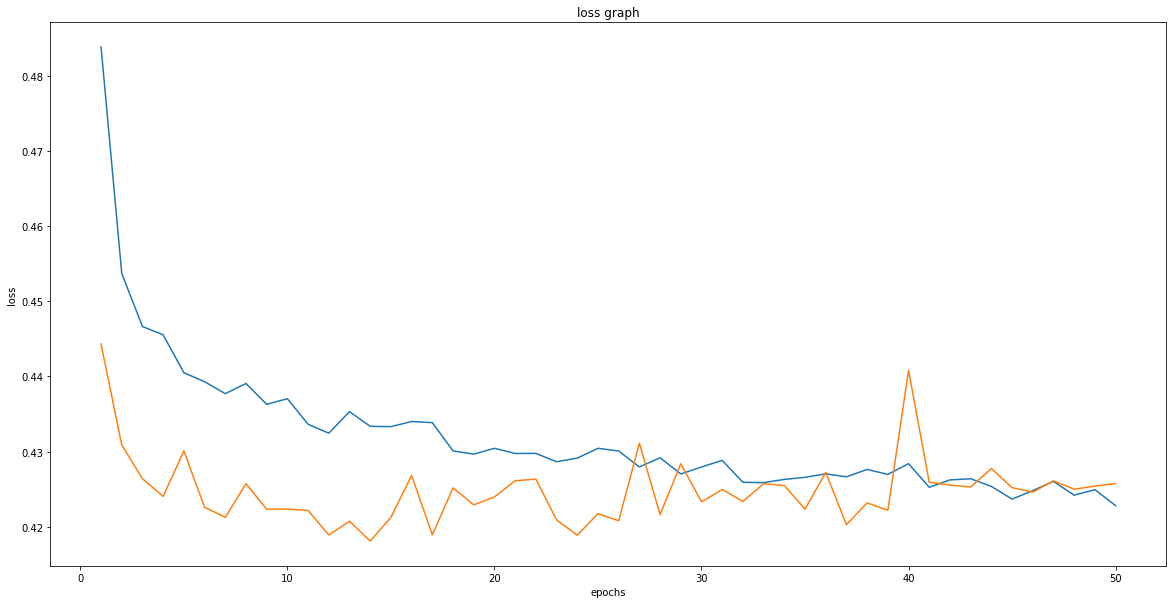

best epoch: 13


In [340]:
plt.figure(figsize=(20,10))
plt.plot(range(1,epochs+1), mean_losses_train)
plt.plot(range(1,epochs+1), mean_losses_valid)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss graph')
plt.show()

print('best epoch: {}'.format(best_epoch))

In [341]:
test_data = dataset[train_records+valid_records:total_records]
test_data = test_data.reset_index()

train_data = dataset[0:train_records]
train_data = train_data.reset_index()

In [352]:
with torch.no_grad():
    x2, x3, c1, c2, c3, c4, num = model(categorical_test_data, numerical_test_data)

In [353]:
# =============================================================================================
# [22 Juni 2020]: 
# Yang dilaporkan di skripsi adalah hasil di data test, bukan di data validasi yang ada sebelumnya.
# Hasil di validasi hanya untuk eksperimen mencoba-coba hyperparameter hingga hasilnya bagus.
# =============================================================================================

from sklearn.metrics import f1_score

test_val = np.argmax(x3, axis=1)
print(confusion_matrix(test_outputs, test_val))
print(classification_report(test_outputs, test_val))
print("Accuracy: ", accuracy_score(test_outputs, test_val))
print("F1 Score: ", f1_score(test_outputs, test_val, average='macro'))

[[1315  295]
 [ 115  275]]
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1610
           1       0.48      0.71      0.57       390

    accuracy                           0.80      2000
   macro avg       0.70      0.76      0.72      2000
weighted avg       0.83      0.80      0.81      2000

Accuracy:  0.795
F1 Score:  0.7190241228070176


In [343]:
embedding = x2.tolist()

In [344]:
x = embedding

In [345]:
# =============================================================================================
# [26 Mei 2020]: 
# Visualisasi embedding diganti dari PCA ke t-SNE karena hasil visualisasi PCA kurang 
# representatif. Paper t-SNE: https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf
# =============================================================================================

tsne = TSNE(n_components=2, verbose=1, perplexity=900, n_iter=300)
principalComponents = tsne.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

[t-SNE] Computing 1999 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.723s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.168163
[t-SNE] KL divergence after 100 iterations with early exaggeration: 38.540684
[t-SNE] KL divergence after 300 iterations: 0.103541


In [346]:
finalDf = pd.concat([principalDf, test_data[['Exited']]], axis = 1)

finalDf0 = finalDf[finalDf['Exited']==0]
finalDf1 = finalDf[finalDf['Exited']==1]

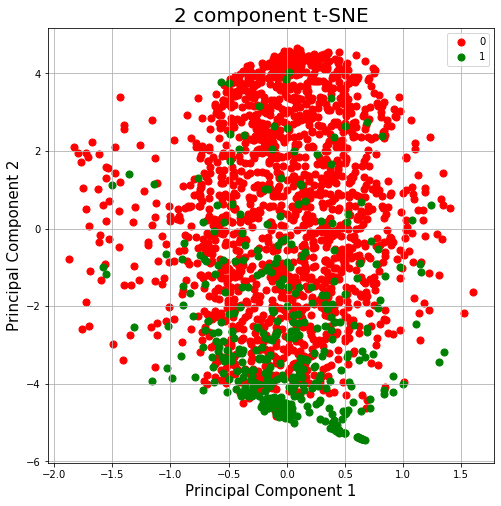

In [347]:
# visualisasi embedding churn dan not churn
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component t-SNE', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Exited'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
# ax.set_xlim(-10,10)
# ax.set_ylim(-10,10)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

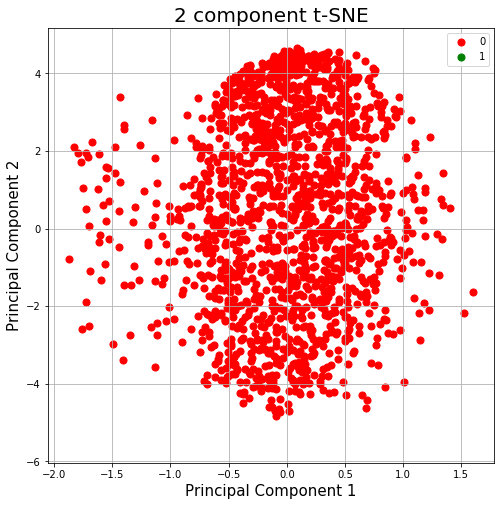

In [348]:
# visualisasi embedding hanya not churn
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component t-SNE', fontsize = 20)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf0['Exited'] == target
    ax.scatter(finalDf0.loc[indicesToKeep, 'principal component 1']
               , finalDf0.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

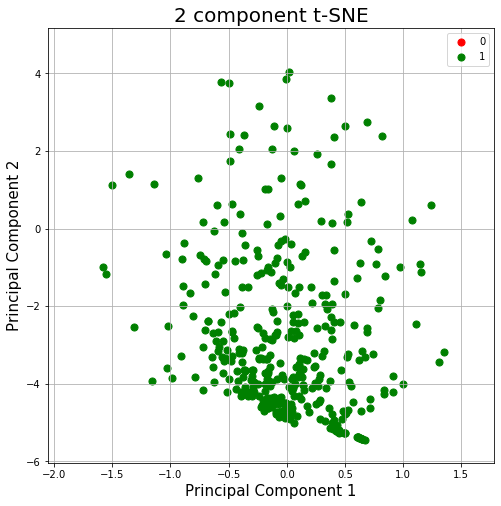

In [349]:
# visualisasi embedding hanya churn
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component t-SNE', fontsize = 20)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf1['Exited'] == target
    ax.scatter(finalDf1.loc[indicesToKeep, 'principal component 1']
               , finalDf1.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [350]:
# =============================================================================================
# [22 Juni 2020]: 
# Selain F1 Score, dilaporkan juga rasio jarak antara embedding intra cluster dan inter cluster
#
# jarak embedding intra cluster adalah jarak antara embedding di suatu kelas ke vector yang ada
# di tengah-tengah kelas tersebut (centroid/center). Jarak diukur dengan Cosine similarity.
# semakin besar angka cosine similarity, semakin kecil jarak yang diukur.
#
# jarak embedding inter cluster adalah jarak antara embedding di suatu kelas ke center dari 
# kelas yang lain (centroid/center). Jarak diukur juga dengan Cosine similarity
#
# Bisa dilihat bahwa dengan tambahan menggunakan autoencoder, inter cluster churn dan 
# inter cluster not churn lebih besar daripada model NN standar. Hal ini berarti bahwa
# penambahan autoencoder bisa membuat keterpisahan antara vektor embedding churn dan tidak churn
#
# Sedangkan untuk jarak intra cluster, model NN standar memberikan hasil yang lebih kecil, sehingga
# dapat disimpulkan NN standar lebih baik daripada metode semi-supervised learning dalam hal 
# pendekatan vektor sesama kelas. 
#
# Namun, jika dihitung rasio antara inter dan intra (inter/intra), model 
# semi-supervised learning memberikan hasil yang lebih baik untuk kelas churn, walaupun NN standar 
# memiliki rasio yang lebih baik untuk kelas not churn
# =============================================================================================

notchurn_emb = x2[test_outputs==0]
sum_notchurn = x2[test_outputs==0].sum(dim=0)
center_notchurn = sum_notchurn/sum_notchurn.norm(p=2)
center_notchurn = center_notchurn.unsqueeze(0)

churn_emb = x2[valid_outputs==1]
sum_churn = x2[valid_outputs==1].sum(dim=0)
center_churn = sum_churn/sum_churn.norm(p=2)
center_churn = center_churn.unsqueeze(0)

cos = nn.CosineSimilarity(dim=1, eps=1e-6)

notchurn_centnotchurn_sim = cos(notchurn_emb, center_notchurn).mean()
notchurn_centchurn_sim = cos(notchurn_emb, center_churn).mean()
churn_centchurn_sim = cos(churn_emb, center_churn).mean()
churn_centnotchurn_sim = cos(churn_emb, center_notchurn).mean()

print("emb not churn, center not churn (not churn intra-cluster): ", notchurn_centnotchurn_sim)
print("emb not churn, center churn (not churn inter-cluster): ", notchurn_centchurn_sim)
print("emb churn, center churn (churn intra-cluster): ", churn_centchurn_sim)
print("emb churn, center not churn (churn inter-cluster): ", churn_centnotchurn_sim)

print("not churn inter-intra cluster ratio: ", notchurn_centnotchurn_sim/notchurn_centchurn_sim)
print("churn inter-intra cluster ratio: ", churn_centchurn_sim/churn_centnotchurn_sim)

emb not churn, center not churn (not churn intra-cluster):  tensor(0.5161, grad_fn=<MeanBackward0>)
emb not churn, center churn (not churn inter-cluster):  tensor(0.5205, grad_fn=<MeanBackward0>)
emb churn, center churn (churn intra-cluster):  tensor(0.3626, grad_fn=<MeanBackward0>)
emb churn, center not churn (churn inter-cluster):  tensor(0.3302, grad_fn=<MeanBackward0>)
not churn inter-intra cluster ratio:  tensor(0.9915, grad_fn=<DivBackward0>)
churn inter-intra cluster ratio:  tensor(1.0980, grad_fn=<DivBackward0>)
